In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve 

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
   

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0  
        return X[self.columns]

In [3]:
# сохраняет метрики качества
def get_metrics(y_test, preds):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)  # игнорирует nan
    
    return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix]

In [4]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), 
                                                    df['cardio'], random_state=0)

In [6]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []


for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [7]:
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)

__1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта__

__2. при обучении моделей обязательно использовать кроссвалидацию__

- LogisticRegression

In [8]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=5, random_state=42)),
])

In [9]:
cv_scores = cross_val_score(classifier, X_train, y_train, cv=8, scoring='roc_auc', n_jobs=-1)

print('CV score is {}+-{}'.format(np.mean(cv_scores), np.std(cv_scores)))

CV score is 0.786840630651526+-0.0032048317025584086


In [10]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)[:, 1]

In [11]:
metrics = []
metrics.append(get_metrics(y_test, y_pred))
metrics

[(0.7842129716710032,
  0.6469542018674966,
  0.8381336405529954,
  0.7302383939774154)]

- RandomForest

In [12]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, 
                                          min_samples_split=10, 
                                          random_state=42,
                                          min_samples_leaf=6))
])

In [13]:
cv_scores = cross_val_score(classifier, X_train, y_train, cv=8, scoring='roc_auc', n_jobs=-1)

print('CV score is {}+-{}'.format(np.mean(cv_scores), np.std(cv_scores)))

CV score is 0.8001800946482686+-0.0035340635517335816


In [14]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)[:, 1]

In [15]:
metrics.append(get_metrics(y_test, y_pred))
metrics

[(0.7842129716710032,
  0.6469542018674966,
  0.8381336405529954,
  0.7302383939774154),
 (0.7991978131498375,
  0.6943461110549206,
  0.7908986175115207,
  0.7394840308073464)]

- KNN

In [16]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier(n_neighbors=12)),
])

In [17]:
cv_scores = cross_val_score(classifier, X_train, y_train, cv=8, scoring='roc_auc', n_jobs=-1)

print('CV score is {}+-{}'.format(np.mean(cv_scores), np.std(cv_scores)))

CV score is 0.719067134571066+-0.004761718236228912


In [18]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)[:, 1]

In [19]:
metrics.append(get_metrics(y_test, y_pred))
metrics

[(0.7842129716710032,
  0.6469542018674966,
  0.8381336405529954,
  0.7302383939774154),
 (0.7991978131498375,
  0.6943461110549206,
  0.7908986175115207,
  0.7394840308073464),
 (0.7172144698893382,
  0.5800472885363436,
  0.8761520737327189,
  0.6979945849203799)]

__3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)__

In [20]:
columns = ['roc_auc_score', 'precision', 'recall', 'f_score']
indexes = ['LogisticRegression', 'RandomForest', 'KNN']

metrics_df = pd.DataFrame(metrics, columns=columns, index=indexes)
metrics_df

,roc_auc_score,precision,recall,f_score
LogisticRegression,0.784213,0.646954,0.838134,0.730238
RandomForest,0.799198,0.694346,0.790899,0.739484
KNN,0.717214,0.580047,0.876152,0.697995


__4. сделать выводы о том, какая модель справилась с задачей лучше других__

RandomForest и LogisticRegression дают сравнительно одинаковые метрики. При этом RandomForest позволяет получить чуть более сбалансированные показатели точности и полноты. Несколько хуже с классификацией справляется KNN.

In [21]:
from sklearn.decomposition import PCA

classifierPCA = Pipeline([
    ('features',feats),
    ('classifier', PCA(n_components=2, random_state=42)),
])

In [22]:
new_x = classifierPCA.fit_transform(X_train)

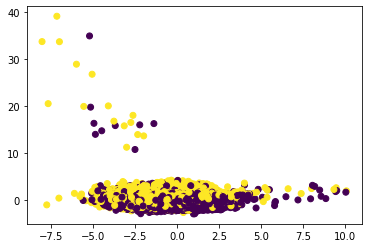

In [23]:
plt.scatter(new_x[:, 0], new_x[:, 1],  c=y_train);

Но, учитывая визуализацию кластеров с понижением размерности, KNN не лучший выбор для классификации (вытянутый "слипшийся" кластер, в который попадает основное число наблюдений, сохраняет свою форму и при n_components=3).

__5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).__

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

При сильном дисбалансе для оценки качества больше подходит precision_recall_curve: так как roc_auc_curve строится в координатах TPR (доля истинно положительных) и FPR (доля ложноположительных ответов), то, к примеру, при сильном дисбалансе в сторону нулевого класса, изменение числа FP (ложных срабатываний) будет незначительно сказываться на FPR  в целом.

Две набора метрик для указанного примера:

In [24]:
n = 100000
y1 = 100
y0 = n - y1

In [25]:
# первая модель
y1_pred = 100

TP = 90
FP = y1_pred - TP
FN = y1 - TP
TN = n - y1 - FP
print(f'confusion_matrix:\n\t{TN}\t{FN}\n\t{FP}\t{TP}')

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'metrics:\n\tTPR-FPR: {TPR, FPR}\n\trecall-precision: {recall, precision}')

confusion_matrix:
	99890	10
	10	90
metrics:
	TPR-FPR: (0.9, 0.0001001001001001001)
	recall-precision: (0.9, 0.9)


In [26]:
# вторая модель
y1_pred = 1000

TP = 90
FP = y1_pred - TP
FN = y1 - TP
TN = n - y1 - FP
print(f'confusion_matrix:\n\t{TN}\t{FN}\n\t{FP}\t{TP}')

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'metrics:\n\tTPR-FPR: {TPR, FPR}\n\trecall-precision: {recall, precision}')

confusion_matrix:
	98990	10
	910	90
metrics:
	TPR-FPR: (0.9, 0.00910910910910911)
	recall-precision: (0.9, 0.09)


Т.е. очевидно, что 2-я модель справляется хуже, хотя обладает той же полнотой (recall = TPR = 0.9 для обеих моделей).

И, хотя число FP меняется от 10 до 910 при переходе от одной модели к другой, по второму измерению для roc-auc разница между моделями (дельта по FPR = 0.0089) не так значительна, как для precision-recall (измерение precision - дельта = 0.81). А, значит, проще опираться на precision-recall.